In [1]:
# Import könyvtárak
import os
import json
from pathlib import Path
import re

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import sys

In [2]:
def find_best_model(models_dir: str):
    """Find and return path to best model checkpoint."""
    models_path = Path(models_dir)
    best_models = list(models_path.glob('best_*.pt'))
    if not best_models:
        raise FileNotFoundError(f"No best_*.pt checkpoints found in {models_dir}")
    # Prefer Final_Balanced, fallback to latest
    final_balanced = [m for m in best_models if 'final_balanced' in m.name.lower()]
    return str(final_balanced[0] if final_balanced else best_models[-1])

In [3]:
class TransformerDataset(Dataset):
    """Dataset for transformer inference."""
    def __init__(self, texts, tokenizer, max_length=384):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

In [4]:
def plot_confusion_matrix(y_true, y_pred, labels, save_path):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=labels, yticklabels=labels,
           ylabel='True label', xlabel='Predicted label',
           title='Confusion Matrix (Test) - Transformer')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    thresh = cm.max() / 2.0 if cm.size else 0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    fig.savefig(save_path, bbox_inches='tight')
    plt.show()
    plt.close(fig)

## Load Best Model & Data

In [5]:
# Configuration
base_output = os.getenv('OUTPUT_DIR', '../output')
processed_dir = os.path.join(base_output, 'processed')
models_dir = os.path.join(base_output, 'models')
eval_dir = os.path.join(base_output, 'reports')

test_path = os.path.join(processed_dir, 'test.csv')

Path(eval_dir).mkdir(parents=True, exist_ok=True)

In [6]:
# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [7]:
# Find and load best model checkpoint
best_checkpoint_path = find_best_model(models_dir)
print(f"Loading best model checkpoint from {best_checkpoint_path}...")

checkpoint = torch.load(best_checkpoint_path, map_location=device)
label2id = checkpoint['label2id']
id2label = {int(k): v for k, v in checkpoint['id2label'].items()}

print(f"Label mapping: {id2label}")

Loading best model checkpoint from /app/output/models/best_final_balanced.pt...
Label mapping: {0: '1', 1: '2', 2: '3', 3: '4', 4: '5'}


In [8]:
# Load model architecture (you need to import the model class from 04)
# For simplicity, we'll assume we saved the model class in the checkpoint
# In practice, you'd import it from the 04 notebook or a shared module

# For this example, let's use BalancedFinalModel
class BalancedFinalModel(nn.Module):
    """Final: Balanced - Production-ready model."""
    def __init__(self, transformer_model, num_classes=5, hidden_dim=256, dropout=0.3):
        super().__init__()
        self.transformer = transformer_model
        self.num_classes = num_classes
        trans_hidden = transformer_model.config.hidden_size
        
        self.adapter = nn.Sequential(
            nn.Linear(trans_hidden, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LayerNorm(hidden_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        self.classifier = nn.Linear(hidden_dim // 2, num_classes)
    
    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.transformer(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=False,
            return_dict=True
        )
        hidden = outputs.last_hidden_state
        
        # Mean pooling
        mask = attention_mask.unsqueeze(-1)
        summed = (hidden * mask).sum(1)
        counts = mask.sum(1).clamp(min=1)
        pooled = summed / counts
        
        adapted = self.adapter(pooled)
        logits = self.classifier(adapted)
        
        output = type('Output', (), {'logits': logits})()
        if labels is not None:
            output.loss = nn.CrossEntropyLoss()(logits, labels)
        return output

# Load base transformer and create model
transformer_model_name = os.getenv('TRANSFORMER_MODEL', 'SZTAKI-HLT/hubert-base-cc')
base_transformer = AutoModel.from_pretrained(transformer_model_name)
model = BalancedFinalModel(base_transformer, num_classes=len(id2label))
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

print("Model loaded successfully")

Model loaded successfully


In [9]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(transformer_model_name)

# Load test data
test_df = pd.read_csv(test_path)
if not {'text', 'label'}.issubset(test_df.columns):
    raise ValueError("Test CSV must contain 'text' and 'label' columns")

X_test = test_df['text'].astype(str).tolist()
y_test = test_df['label'].astype(str).tolist()

print(f"Test samples: {len(X_test)}")
display(test_df.head())

Test samples: 701


,text,label,word_count,avg_word_len
0,3.1.4.a bank kizárja a felelősségét arra vonat...,4-Érthető,42,7.904762
1,késedelmes fizetés esetén időarányosan évi 15%...,4-Érthető,61,7.327869
2,"9.4 a felhasználó köteles lehetővé tenni, hogy...",3-Többé/kevésbé megértem,49,6.469388
3,a felhasználó a választott kellékszavatossági ...,3-Többé/kevésbé megértem,27,5.962963
4,5.1.1. egyedi hirdetési szerződéssel nem rende...,4-Érthető,185,6.664865


## Run Evaluation on Test Set

In [10]:
# Create dataset and dataloader
batch_size = int(os.getenv('BATCH_SIZE', '8'))
max_length = int(os.getenv('MAX_LENGTH', '384'))
test_dataset = TransformerDataset(X_test, tokenizer, max_length)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [11]:
# Run inference
print("Running evaluation on test set...")
y_pred = []
disable_tqdm = not sys.stdout.isatty()

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating", disable=disable_tqdm):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        
        y_pred.extend([id2label[int(p)] for p in preds.cpu().numpy()])

print("Evaluation complete!")

Running evaluation on test set...
Evaluation complete!


## Generate Classification Report

In [12]:
# Generate classification report
labels = sorted(list(set(y_test) | set(y_pred)))
report = classification_report(y_test, y_pred, labels=labels, output_dict=True, zero_division=0)

# Add ordinal regression metrics (MAE, RMSE)
def labels_to_numeric(labels):
    out = []
    for l in labels:
        m = str(l).strip()
        if m and m[0].isdigit():
            out.append(int(m[0]))
        else:
            out.append(0)
    return np.array(out)

y_true_num = labels_to_numeric(y_test)
y_pred_num = labels_to_numeric(y_pred)
mae = mean_absolute_error(y_true_num, y_pred_num)
rmse = np.sqrt(mean_squared_error(y_true_num, y_pred_num))

report['mae'] = float(mae)
report['rmse'] = float(rmse)
weighted_f1 = report.get('weighted avg', {}).get('f1-score', 0)

print(f"\n{'='*60}")
print(f"TEST RESULTS")
print(f"{'='*60}")
print(f"Test Accuracy: {report['accuracy']:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"{'='*60}\n")


TEST RESULTS
Test Accuracy: 0.0000
Weighted F1: 0.0000
MAE: 0.7632
RMSE: 1.0992



In [13]:
# Display detailed classification report
from sklearn.metrics import classification_report as cr_display
print("\nDetailed Classification Report:")
print(cr_display(y_test, y_pred, labels=labels, zero_division=0))


Detailed Classification Report:
                          precision    recall  f1-score   support

                       1       0.00      0.00      0.00       0.0
1-Nagyon nehezen érthető       0.00      0.00      0.00      34.0
                       2       0.00      0.00      0.00       0.0
       2-Nehezen érthető       0.00      0.00      0.00      83.0
                       3       0.00      0.00      0.00       0.0
3-Többé/kevésbé megértem       0.00      0.00      0.00     152.0
                       4       0.00      0.00      0.00       0.0
               4-Érthető       0.00      0.00      0.00     217.0
                       5       0.00      0.00      0.00       0.0
       5-Könnyen érthető       0.00      0.00      0.00     215.0

                accuracy                           0.00     701.0
               macro avg       0.00      0.00      0.00     701.0
            weighted avg       0.00      0.00      0.00     701.0



In [14]:
# Save report
report_path = os.path.join(eval_dir, '05-evaluation_test_report.json')
with open(report_path, 'w', encoding='utf-8') as f:
    json.dump(report, f, ensure_ascii=False, indent=2)
print(f"Saved test report to {report_path}")

Saved test report to /app/output/reports/05-evaluation_test_report.json


## Confusion Matrix

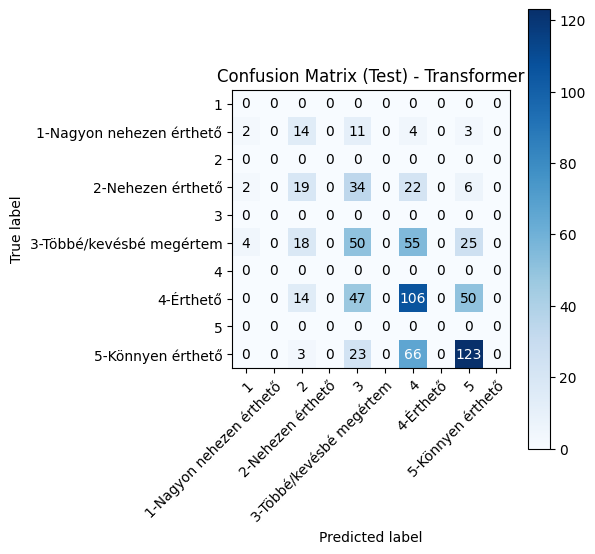

Saved test confusion matrix to /app/output/reports/05-evaluation_test_confusion_matrix.png


In [15]:
# Plot and save confusion matrix
cm_path = os.path.join(eval_dir, '05-evaluation_test_confusion_matrix.png')
plot_confusion_matrix(y_test, y_pred, labels, cm_path)
print(f"Saved test confusion matrix to {cm_path}")

## Evaluation Complete!

A modell értékelése befejezve a test set-en.